# Customer Data Aanlysis

### ---- Analyzing and Modeling on a credit card customer dataset for business insights.



## Table of Content.

- Notebook I: Data Cleaning and EDA.


- Notebook II: Churn Prediction.

         
- Notebook III: Customer Segmentation.


- Notebook IV: Customer Lifetime Value Analysis.

# This is Notebook IV : Customer Value Analysis.

0. Data Loading.


1. Data Validation. 

        Question: What is 'Total_Revolving_Bal'?
        Answer: It is the (average) Monthly Revolving Balance.
    
     
2. Customer Lifetime Value, Definition and Calculation.

   

    
3. Visualization and Analysis.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import pickle


## 0. Data Loading.

In [2]:
# load data processed and saved in Notebook I

with open('1_data_after_notebook1.pkl', 'rb') as pickle_file:
    df = pickle.load(pickle_file)

In [3]:
df

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Divorced,Married,Single,Unknown,ClientNum_Cluster
0,0,45,0,3,1.000000,3.0,1,39,5,1,...,1.335,1144,42,1.625,0.061,0,1,0,0,1
1,0,49,1,5,3.000000,1.0,1,44,6,1,...,1.541,1291,33,3.714,0.105,0,0,1,0,1
2,0,51,0,3,3.000000,4.0,1,36,4,1,...,2.594,1887,20,2.333,0.000,0,1,0,0,0
3,0,40,1,4,1.000000,1.0,1,34,3,4,...,1.405,1171,20,2.333,0.760,0,0,0,1,1
4,0,40,0,3,0.000000,3.0,1,21,5,1,...,2.175,816,28,2.500,0.000,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,0,2,3.000000,2.0,1,40,3,2,...,0.703,15476,117,0.857,0.462,0,0,1,0,1
10123,1,41,0,2,2.061106,2.0,1,25,4,2,...,0.804,8764,69,0.683,0.511,1,0,0,0,0
10124,1,44,1,1,1.000000,1.0,1,36,5,3,...,0.819,10291,60,0.818,0.000,0,1,0,0,0
10125,1,30,0,2,3.000000,2.0,1,36,4,3,...,0.535,8395,62,0.722,0.000,0,0,0,1,0


## 1. Data Validation.

### Conclusion summary in this section:

- Found Relations among the variables 'Avg_Utilization_Ratio', 'Credit_Limit', 'Total_Revolving_Bal', and 'Avg_Open_To_Buy'.


- Clarified the Precise Meaning of the variable 'Total_Revolving_Bal',

  it is the (average) monthly revolving balance, 
  
  i.e. unpaid balance that generates interest. 
  
  This is crucial for CLV estimate.

### Question 1: what is the precise meaning of the feature 'Total_Revolving_Bal'? 

Is it total revolving balance during the 12-months period? Or a monthly average?

This was not clear from the original the column description came with the dataset.

We shall validate the data to find out.

In [6]:
# initiate an auxiliary dataframe for data validation.
balance_df = pd.DataFrame()

# create column 'Avg_Util', the average monthly utilization, 
# that is, balance not paid in each monthly cycle.
balance_df['Avg_Util'] = df.Avg_Utilization_Ratio * df.Credit_Limit

# copy column 'Total_Revolving_Bal' for comparison
balance_df['Total_Revolving_Bal'] = df.Total_Revolving_Bal

# Difference btw the two columns
balance_df['Diff'] = balance_df.Avg_Util - balance_df.Total_Revolving_Bal
# Relative difference
balance_df['Diff_ratio'] = balance_df.Diff / (balance_df.Total_Revolving_Bal + balance_df.Avg_Util + 0.01)


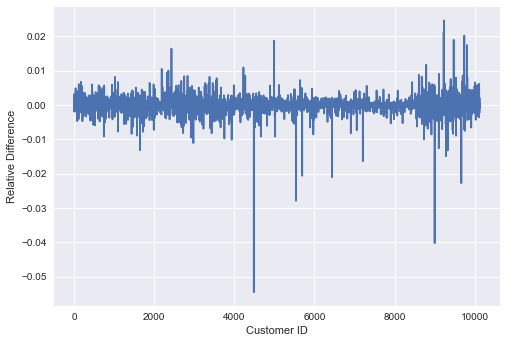

In [7]:
# Plot the 'Diff_ratio'
balance_df.Diff_ratio.plot()
plt.ylabel('Relative Difference')
plt.xlabel('Customer ID')
plt.show()

In [83]:
# Also check the mean absolute difference. 
balance_df.Diff.mean()

0.009144712155632869

In [84]:
# Another related column 'Limit_Minus_Open'
balance_df['Limit_Minus_Open'] = df.Credit_Limit - df.Avg_Open_To_Buy

In [87]:
# One more sanity check
balance_df['Diff_2'] = balance_df.Limit_Minus_Open - balance_df.Avg_Util
balance_df.Diff_2.mean()

-0.009144712155632869

### Answer 1: 
the above investigations confirm that 'Total_Revolving_Bal' = 'Avg_Utilization_Ratio'  x  'Credit_Limit'.

#### That is, 'Total_Revolving_Bal' can be think of as the average monthly unpaid balance that incur interest. 

#### This is crucial for computing customer lifetime value (CLV).

## 2. Customer Annual Value Analysis.

- We consider two major source of value that a customer could bring:
     1. Interest.
     2. Transaction fee.

- In order to compute these, we need to know about 
     1. Interest Rate (APR), this could vary with customer.
     2. Rate on transaction fee.
     
Below, we define a function to compute value generated by customer in the year.

In [91]:
def customer_yearly_value(df, trans_fee_rate=0.015):
    
    """This function computes the value that a credit card customer generates, 
    including interest and transaction fee.
    
    INPUT:
    
    df: a pd.DataFrame, must contain columns: 
      'APR' -- annual percentage rate.
      'Total_Revolving_Bal' -- average montly revolving/unpaid balance.
      'Total_Trans_Amt' -- Total Amount of transaction in the year.
    
    trans_fee_rate: a float between 0 and 1, represents the rate of transaction fee.
    
    
    RETURN:
    
    value_df: a pd.DataFrame that contains 1 columns
           'Value' -- the value that a customer's transaction yield.
    
    """
    
    df['Value'] = df.Total_Revolving_Bal * df.APR + df.Total_Trans_Amt * trans_fee_rate
    
    return df[['Value']]

#### We shall assume the APR for every customer is 18%. In reality, we should have a column storing the indivisual APR for each customer.

In [93]:
# set 'APR' to 18% for every customer
df['APR'] = 0.18

value_df = customer_yearly_value(df)

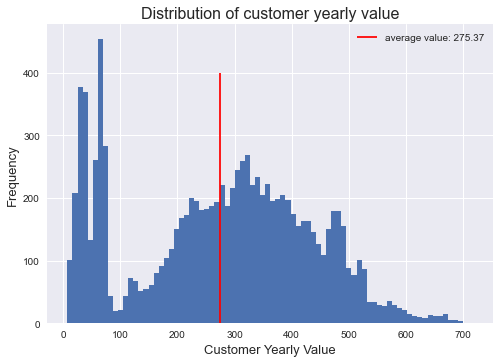

In [105]:
# visualize distribution of customer yearly value.

value_df.Value.sort_values().hist(bins=80)
label = f'average value: {round(value_df.Value.mean(),2)}'
plt.vlines(value_df.Value.mean(), ymin=0, ymax=400, color='red', label=label)
plt.xlabel('Customer Yearly Value', fontsize =13)
plt.ylabel('Frequency', fontsize =13)
plt.title('Distribution of customer yearly value', fontsize = 16)
plt.legend()
plt.show()

## 3. Customer Lifetime Value given Churn Probability